In [8]:
import argparse
import cv2
import numpy as np
import torch

from pytorch_grad_cam import GradCAM, \
    ScoreCAM, \
    GradCAMPlusPlus, \
    AblationCAM, \
    XGradCAM, \
    EigenCAM, \
    EigenGradCAM, \
    LayerCAM, \
    FullGrad

from pytorch_grad_cam import GuidedBackpropReLUModel
from pytorch_grad_cam.utils.image import show_cam_on_image, \
    preprocess_image
from pytorch_grad_cam.ablation_layer import AblationLayerVit

import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torchvision.transforms.v2 import ToPILImage
import timm
torch.set_default_device('cuda')


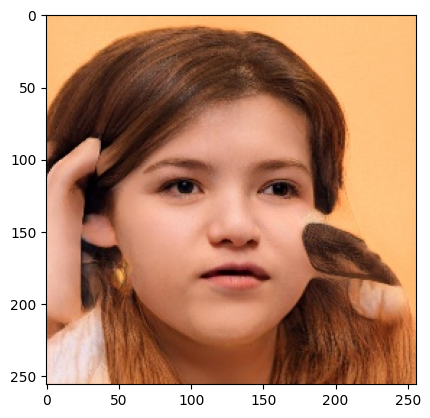

[DoubleResidualDWSeparableConv2d(
  (activation): GELU(approximate='none')
  (conv1): DoubleDepthwiseSeparableConv2d(
    (activation): GELU(approximate='none')
    (depthwise): Sequential(
      (0): Conv2d(3, 3, kernel_size=(3, 1), stride=(1, 1), padding=same, groups=3, bias=False)
      (1): Conv2d(3, 18, kernel_size=(1, 3), stride=(1, 1), padding=same, groups=3, bias=False)
      (2): BatchNorm2d(18, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (pointwise): Sequential(
      (0): Conv2d(18, 18, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(18, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GELU(approximate='none')
    )
  )
  (conv2): DoubleDepthwiseSeparableConv2d(
    (activation): GELU(approximate='none')
    (depthwise): Sequential(
      (0): Conv2d(18, 18, kernel_size=(3, 1), stride=(1, 1), padding=same, groups=18, bias=False)
      (1): Conv2d(18, 18, kernel_size=(1, 3), stride=(1, 1), padding=s

In [27]:
def reshape_transform(tensor, height=14, width=14):
    result = tensor[:, 1:, :].reshape(tensor.size(0),
                                      height, width, tensor.size(2))

    # Bring the channels to the first dimension,
    # like in CNNs.
    result = result.transpose(2, 3).transpose(1, 2)
    return result

def rt(tensor, height=8, width=8):
    result = tensor.reshape(tensor.size(0), height, width, tensor.size(2))
    result = result.transpose(2, 3).transpose(1, 2)
    return result


if __name__ == '__main__':
    """ python vit_gradcam.py --image-path <path_to_image>
    Example usage of using cam-methods on a VIT network.

    """
    
    # REAL ARGUMENTS FOR REAL MEN
    method = 'gradcam++'
    use_cuda = True
    image_path = r"datasets\140k Real vs Fake\real_vs_fake\real-vs-fake\train\fake\00B4R41FLE.jpg"
    eigen_smooth = True
    aug_smooth = True
    
    img = plt.imread(image_path)
    plt.imshow(img), plt.show()
    
    methods = \
        {"gradcam": GradCAM,
         "scorecam": ScoreCAM,
         "gradcam++": GradCAMPlusPlus,
         "ablationcam": AblationCAM,
         "xgradcam": XGradCAM,
         "eigencam": EigenCAM,
         "eigengradcam": EigenGradCAM,
         "layercam": LayerCAM,
         "fullgrad": FullGrad}


    if method not in list(methods.keys()):
        raise Exception(f"method should be one of {list(methods.keys())}")

    # This one does work, just uncomment the reshape_transform argument in the cam methods below.
    # Results still look a bit odd
    # model = torch.hub.load('facebookresearch/deit:main', 'deit_tiny_patch16_224', pretrained=True)
    # target_layers = [model.blocks[-1].norm1]

    # NO IDEA HOW TO MAKE THIS ONE WORK
    # model = timm.create_model('swin_tiny_patch4_window7_224', pretrained=False, num_classes=2)
    # model.load_state_dict(torch.load('CollectedData\Models\swinNewInit-0_Epoch25_Batch64_LR0.001_Momentum0.9'))
    # target_layers = [model.layers[-1].blocks[-1].norm1]
    
    # Very stripey vertically, may be passing in the wrong layer?
    # model = torch.load('CollectedData\Models\swinNewInit-0_Epoch25_Batch64_LR0.001_Momentum0.9')
    # target_layers = [model.layers[-1].blocks[-1].norm1]

    # Very stripey vertically, may be passing in the wrong layer?
    # model = timm.models.swin_base_patch4_window7_224_in22k(pretrained=True, num_classes = 2)
    # target_layers = [model.layers[-1].blocks[-1].norm1]


    # Visualizable VIT, this one should work but IDK which layer to use
    # model = torch.load(r'CollectedData\Models\visualizableVIT-0_Epoch25_Batch64_LR0.001_Momentum0.9') # Replace with model path
    # modelChildren = list(model.children())
    # target_layers = [] # Change which layer we look at, it's a lot easier to examine modelChildren in the debugger


    # Visualizable VIT2
    # model = torch.load(r'CollectedData\Models\visualizableVIT2-0_Epoch25_Batch64_LR0.001_Momentum0.9') # Replace with model path
    # # modelChildren = list(model.children())
    # modelChildren = list(model.modules())
    # # print(modelChildren) # Uncomment me at your own risk... It's a long model
    # target_layers = [model.model.norm] # Change which layer we look at, it's a lot easier to examine modelChildren in the debugger


    # Custom CNN, this one does work
    # model = torch.load('CollectedData\Models\DWSConvNet3_learnedPoolingHwy-0_Epoch25_Batch64_LR0.001_Momentum0.9') # Replace with model path
    # modelChildren = list(model.children())
    # # print(modelChildren) # Uncomment me at your own risk... It's a long model
    # target_layers = [*modelChildren[11:16]] # Change which layer we look at, it's a lot easier to examine modelChildren in the debugger
    
    # RCNN
    # model = torch.load(r'CollectedData\Models\customResnet-Aug-0_Epoch25_Batch1_LR0.001_Momentum0.9') # Replace with model path
    # modelChildren = list(model.children())
    # # print(modelChildren) # Uncomment me at your own risk... It's a long model
    # target_layers = [*modelChildren[11:16]] # Change which layer we look at, it's a lot easier to examine modelChildren in the debugger
    
    # SepNet
    model = torch.load(r'CollectedData\Models\superSepNetLarge-NAdam-Aug-0_Epoch25_Batch32_LR0.0001_Momentum0.9') # Replace with model path
    modelChildren = list(model.children())
    print(modelChildren) # Uncomment me at your own risk... It's a long model
    print(len(modelChildren))
    selectedLayers = modelChildren[10:35]
    LAYERS_LIST = [[l] for l in selectedLayers]
    
    
    camImages = []
    for target_layers in LAYERS_LIST:
    
        model.eval()

        if use_cuda:
            model = model.cuda()


        if method not in methods:
            raise Exception(f"Method {method} not implemented")

        if method == "ablationcam":
            cam = methods["ablationcam"](model=model,
                                    target_layers=target_layers,
                                    #    use_cuda=use_cuda,
                                    reshape_transform=rt,
                                    ablation_layer=AblationLayerVit())
        else:
            cam = methods[method](model=model,
                                    target_layers=target_layers,
                                    #    use_cuda=use_cuda,
                                    #    reshape_transform=rt
                                    )

        rgb_img = cv2.imread(image_path, 1)[:, :, ::-1]
        rgb_img = cv2.resize(rgb_img, (256, 256))
        rgb_img = np.float32(rgb_img) / 255
        input_tensor = preprocess_image(rgb_img, mean=[0.5, 0.5, 0.5],
                                        std=[0.5, 0.5, 0.5])

        # If None, returns the map for the highest scoring category.
        # Otherwise, targets the requested category.
        targets = None

        # AblationCAM and ScoreCAM have batched implementations.
        # You can override the internal batch size for faster computation.
        cam.batch_size = 32

        grayscale_cam = cam(input_tensor=input_tensor,
                            targets=targets,
                            eigen_smooth=eigen_smooth,
                            aug_smooth=aug_smooth)

        # Here grayscale_cam has only one image in the batch
        grayscale_cam = grayscale_cam[0, :]

        cam_image = show_cam_on_image(rgb_img, grayscale_cam)
        camImages.append(torch.tensor(cam_image).transpose(2, 0))
    
    imageGrid = make_grid(torch.stack(camImages, dim=0), nrow=6).transpose(0, 2).cpu().numpy()
    outFileName = f'{method}_cam.png'
    cv2.imwrite(outFileName, imageGrid)
    
    print(f'Exported result to {outFileName}!')
